In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import label2rgb
from skimage.morphology import skeletonize
import math
import seaborn as sns
from IPython.display import display
from scipy.signal import find_peaks
from scipy import stats, optimize

In [2]:
def length(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def angle_between(x1, y1, x2, y2):
    ang = np.arctan(np.divide(np.absolute(y2-y1), np.absolute(x2-x1), out=np.full((1), np.inf), where=np.absolute(x2-x1)!=0))
    return np.degrees(ang[0])

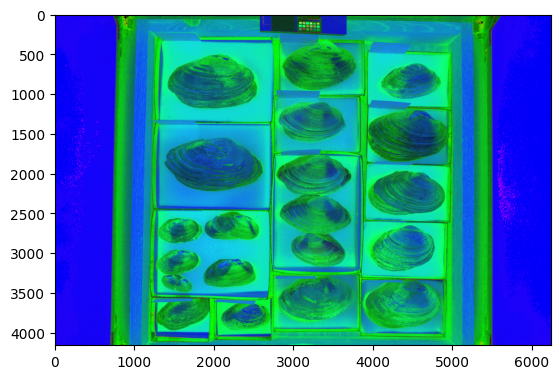

In [3]:
img = cv2.imread("20230728_01T.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
final_mask = np.zeros_like(img)
plt.imshow(img)

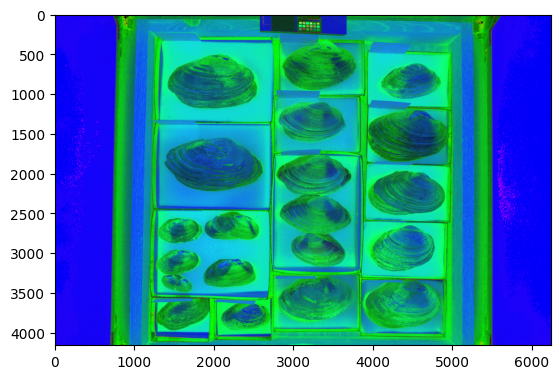

In [4]:
# img = cv2.bilateralFilter(img, 15, 100, 100)
# img = cv2.GaussianBlur(img,(5,5),0)
plt.imshow(img)

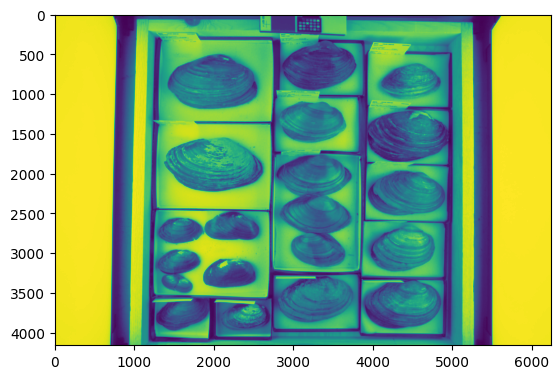

In [5]:
gray = img[:,:,2]
gray = cv2.bilateralFilter(gray,15, 100, 100)
# plt.imshow(gray)
# mask = np.zeros((gray.shape),np.uint8)
# kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(100,50))

# close = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel1)
# div = np.float32(gray)/(close)
# res = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))
# res2 = cv2.cvtColor(res,cv2.COLOR_GRAY2BGR)
plt.imshow(gray)

In [6]:
ddepth = cv2.CV_16S
kernel_size = 3
scale = 1
delta = 0

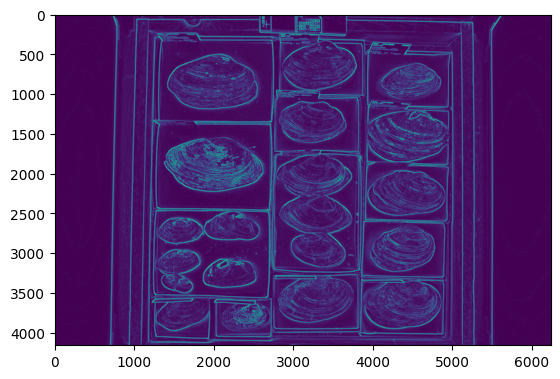

In [7]:
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=-1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
# grad_y = cv.Scharr(gray,ddepth,0,1)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=-1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)


abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)


grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.imshow(cv2.normalize(grad,grad,0,255,cv2.NORM_MINMAX))

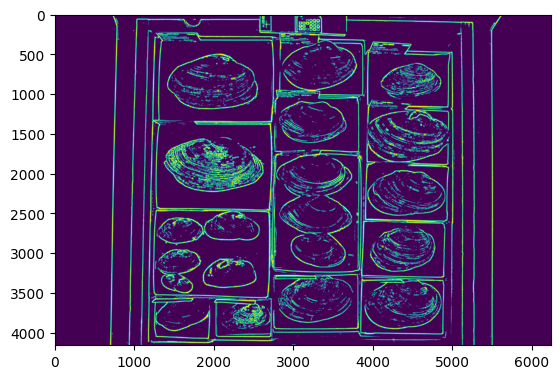

In [8]:
_, tmp_mask = cv2.threshold(grad,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(tmp_mask)

In [10]:
lines  = [line for line in np.squeeze(cv2.HoughLinesP(tmp_mask, 1, np.pi/180, 360, None, 50, 1))]
angles = [angle_between(*line) for line in lines]
sigma = (len(angles)**(-1./(1+4)))/2    #scotts factor
kde = stats.gaussian_kde(angles, bw_method=sigma*2)
xx = np.linspace(-20, 120, 10000)
peaks, _ = find_peaks(kde(xx))
peak_values = list(zip(xx[peaks], kde(xx)[peaks]))
p1, p2 = (i[0] for i in sorted(peak_values, key=lambda x:x[1])[::-1][:2])
lines = [line for line in lines if np.any(np.absolute(angle_between(*line)-peak_values)<5) and length(*line)>100 and length(*line)<500]
angles = [angle_between(*line) for line in lines]
lengths = [length(*line) for line in lines]
print(peak_values)
# plt.plot(xx, kde(xx))
# plt.plot(xx[peaks], kde(xx)[peaks], 'x')
# sigma = (len(lengths)**(-1./(1+4)))/2    #scotts factor
# kde = stats.gaussian_kde(lengths, bw_method=sigma*2)
# xx = np.linspace(0, np.max(tmp_mask.shape), 10000)
# peaks, _ = find_peaks(kde(xx))
# peak_values = xx[peaks]
# print(xx[peaks], kde(xx)[peaks])
# plt.plot(xx, kde(xx))
# plt.plot(xx[peaks], kde(xx)[peaks], 'x')

[(2.668266826682668, 0.02281492714508053), (40.5980598059806, 0.005528192667355948), (89.08490849084909, 0.01411078816498253)]


In [11]:
hor, vert = [], []
for angle, line in zip(angles, lines):
    if angle>max(p1, p2):
        vert.append(line)
    if angle<min(p1, p2):
        hor.append(line)

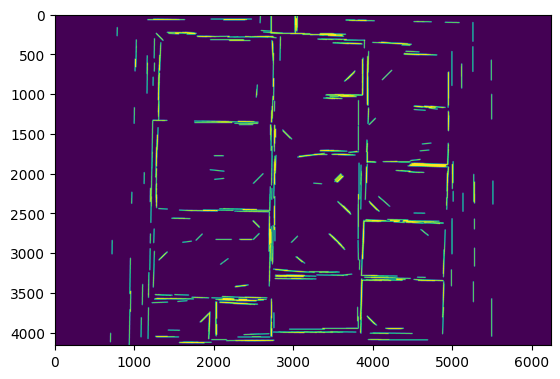

In [12]:
im = np.zeros_like(tmp_mask)
for line in lines:
    cv2.line(im, (line[0], line[1]), (line[2], line[3]), 255, 10)
plt.imshow(im)